<div style="font-weight: bold" align="center">
    <div style="font-size: xx-large; color:#3d6f91">Teoría de la Información</div><br>
    <div style="font-size: x-large; color:gray">Análisis spikes neuronales</div><br>
    <div style="font-size: large; color: #5D8AA8">Óscar Gómez Borzdynski y Alejandro Cabana Suárez</div><br></div><hr>
</div>

In [2]:
%%html
<style>
    h1, h2, h3 {color: #3d6f91;}
    b {color: #5D8AA8;}
</style>

# TODO:

* Calcular información mutua para todos los ficheros con resoluciones grandes <b style='color: green'>DONE</b>
* Función transferencia info, que es copiar la de informacion mutua y devolver dividiendo entre la entropia <b style='color: green'>DONE</b>
* Calcular información mutua para todos los ficheros utilizando los bursts como codificación <b style='color: green'>DONE</b>
* Gráficas interspike para explicar los thresholds en get_bursts y en la selección de resoluciones <b style='color: green'>DONE</b>
* Gráficas de una zona de los spikes para explicar los thresholds en get_spikes <b style='color: orange'>DOING</b>
* Gráficas de cada coso para ver cómo queda (Heatmaps, por tamaño de palabra...) <b style='color: green'>DONE</b>
* Comparar transferencia de información LP->VD frente a VD->LP 
* 16 gráficas de transferencia de información (una por tamaño de palabra) con 3 lineas donde cada una corresponden a un fichero <b style='color: green'>DONE</b>
* Shiftear una serie y medir la mi en función del retraso
* Ver cuántos spikes pillamos sin querer al ampliar la resolucion

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import pickle
import seaborn as sns

# Análisis inicial
Comenzamos analizando los datos proporcionados por el profesor.

En primer lugar vemos la necesidad de encontrar los picos de cada una de las series temporales, para ello decidimos implementar la función `get_spikes()` que sigue el siguiente pseudo-código:

<hr>

```
crear una serie del mismo tamaño rellena de 0's

a lo largo de la serie:

    if ((serie supera threshold superior) y (no estamos ya dentro de un spike)) :
        marcar inicio spike
        
    if ((serie desciende de threshold inferior) y (estamos en un spike)) :
        marcar fin spike
        obtener el índice del máximo dentro del spike
        colocar un 1 en la serie para dicho índice
        
devolver la serie    
```

<hr>

Para definir los thresholds dibujamos el comienzo de las series. En las gráficas de debajo hemos colocado líneas horizontales en los thresholds escogidos.

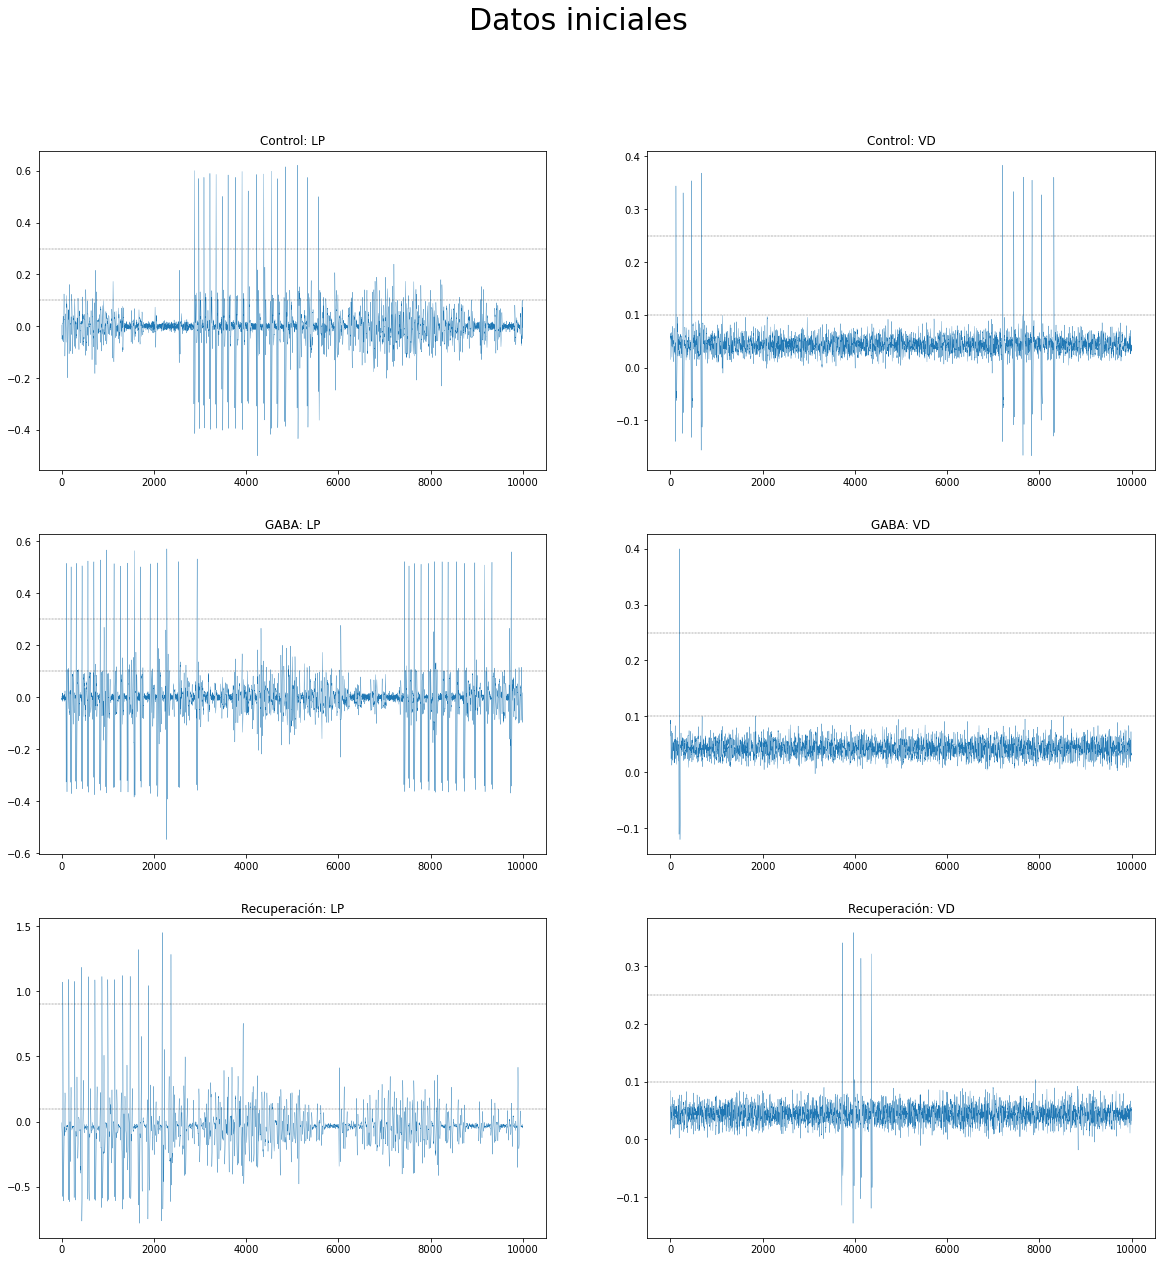

In [20]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoG.txt",
              "./DatosSinapsisArtificial/TrozoR.txt"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
thresholds = [{"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.9, 0.1], "VD": [0.25, 0.1]}]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Datos iniciales", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float,
                     sep='\s+', decimal=',', index_col=False).head(10000)
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][0], ls="-.", c='black', lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][1], ls="-.", c='black', lw=0.3)
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][0], ls="-.", color='black', lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][1], ls="-.", color='black', lw=0.3)
    plt.title(f"{titles[i]}: VD")

# Spikes

En las gráficas siguientes vemos los puntos escogidos por la función `get_spikes()`, estos puntos están expresados por cruces en dichas posiciones.

In [21]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",,
              "./DatosSinapsisArtificial/TrozoG.txt"
              "./DatosSinapsisArtificial/TrozoR.txt"]
bin_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
             "./DatosSinapsisArtificial/TrozoG_bin.csv",
             "./DatosSinapsisArtificial/TrozoR_bin.csv"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Detección de spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False, nrows=10000)
    df2 = pd.read_csv(bin_files[i],nrows=10000)
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.plot(df2[df2["LP_bin"] == 1]["LP"], 'x', c='orange')
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.plot(df2[df2["VD_bin"] == 1]["VD"], 'x', c='orange')
    plt.title(f"{titles[i]}: VD")

SyntaxError: invalid syntax (<ipython-input-21-5b76923d2d55>, line 1)

# Distancia entre spikes

En esta práctica debemos calcular:

* Entropía
* Información mutua
* Entropía normalizada

Para todos estos cálculos debemos decidir 2 parámetros, el tamaño de bin, al que hemos llamado resolución y el tamaño de palabra (cuántos bins se analizan simultáneamente). En todos los casos hemos decidido tomar un tamaño de palabra máximo de 8 bins. 

Para decidir la resolución obtenemos un histograma de la distancia entre dos spikes seguidos. Hemos colocado una barra vertical en la resolución máxima que calcularemos. Hemos escogido este límite pese a que en algunos casos introducimos dos spikes en un solo bin. Dado que calcularemos todas las resoluciones entre 1 y ese límite podremos analizar qué implica seleccionar un tamaño de bin demasiado grande.

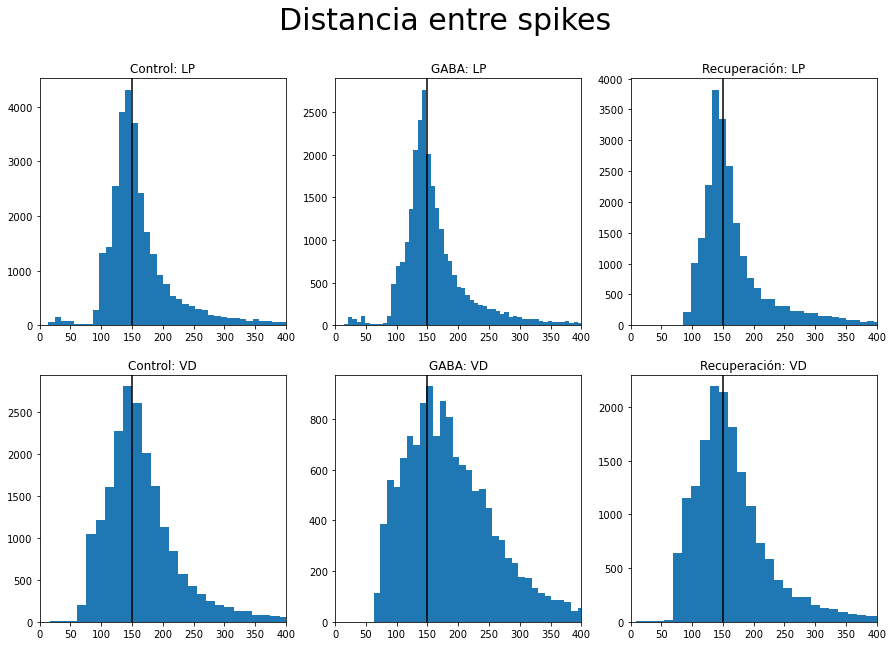

In [5]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: LP")
    
    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: VD")

Podemos ver que en la mayoría de los casos el punto que deberíamos seleccionar para dejar fuera solo los errores es de una resolución de aproximadamente 60, pero llegando al máximo del histograma esperamos escoger la distancia mas habitual.

Para modificar la resolución de las series obtenidas previamente definimos la función `resolution()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en fragmentos de tamaño máximo igual a la resolución

para cada fragmento:
    si no existe ningún spike en la serie original -> 0
    si existe algún spike en la serie original -> 1
    
reagrupar todos los fragmentos en una serie de tamaño techo(tamaño original/resolución)
```

<hr>

Luego para calcular las métricas definimos la función `transfer_info()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en ventanas solapadas de tamaño longitud de la palabra

para cada ventana:
    obtener el número que se obtiene al transformar de binario a decimal
    combinar ambos números para la entropía conjunta 
    
obtener las probabilidades de aparición de cada número

calcular las entropías de cada columna
calcular la entropía conjunta
calcular la información mutua como la suma de las entropías individuales menos la conjunta
calcular las entropías normalizadas

devolver todos los cálculos realizados
```

<hr>

Guardamos todos los cálculos realizados en ficheros específicos para cada fragmento de datos.


# Entropía normalizada

Una vez realizados todos los cálculos podemos pasar a evaluar los resultados obtenidos

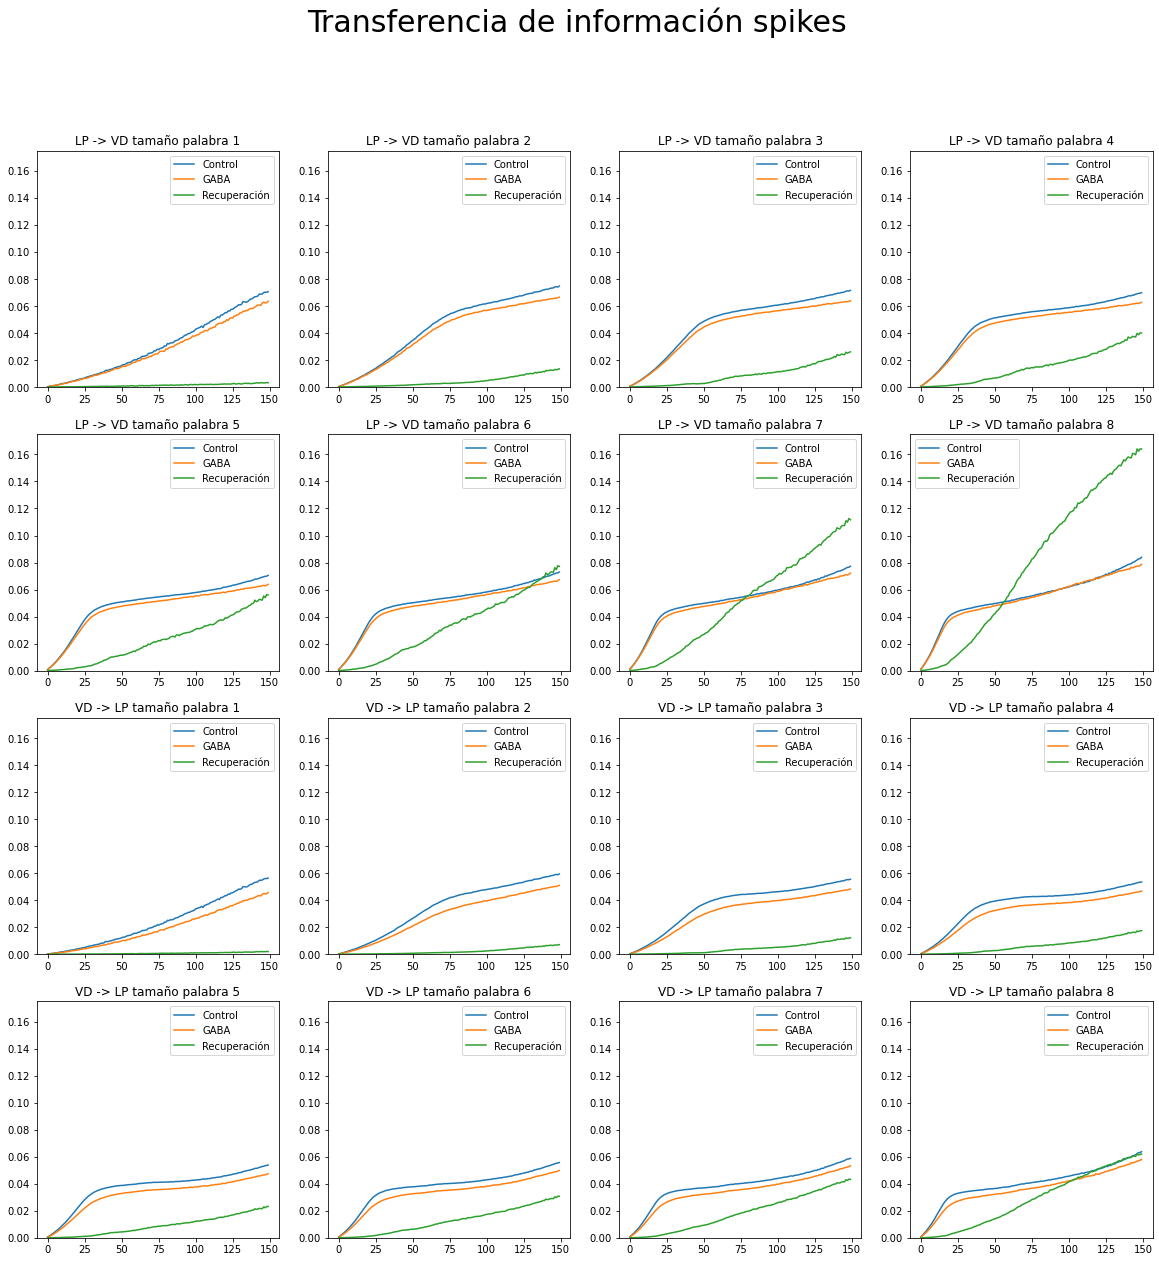

In [6]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información spikes", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.ylim((0,0.175))
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.175))
    plt.legend()

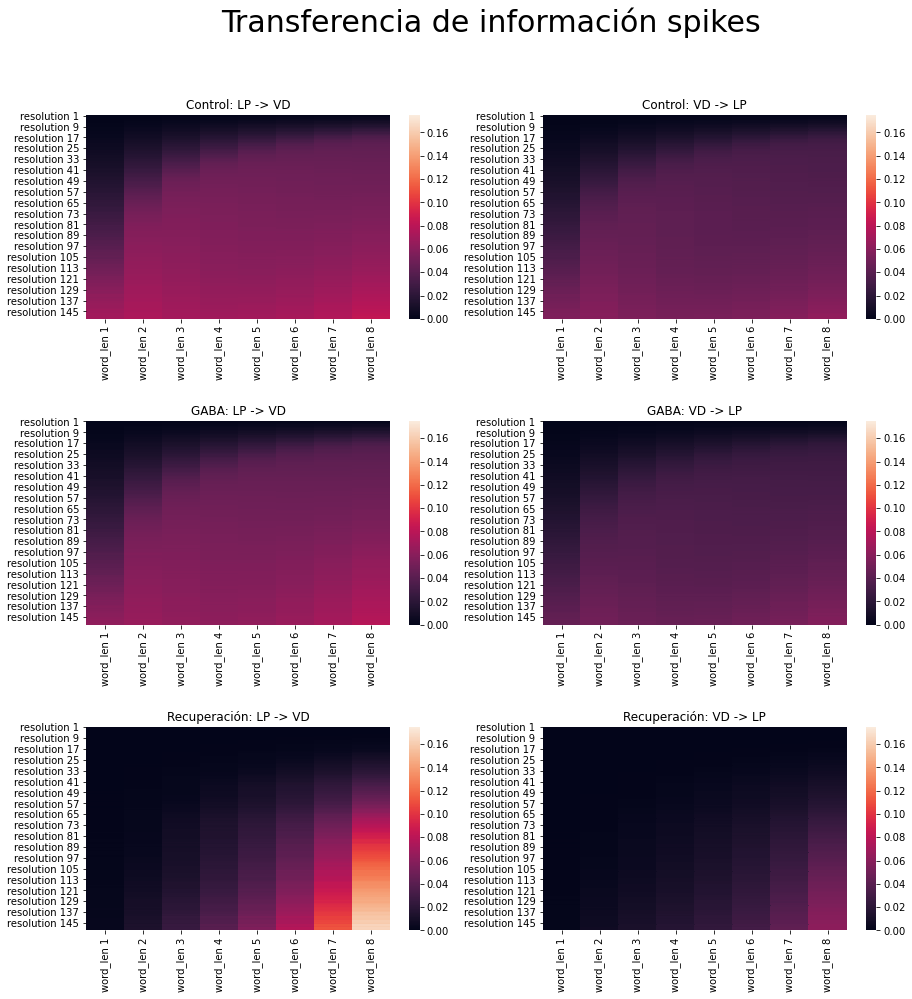

In [7]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información spikes", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.175)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.175)
    plt.title(f"{labels[i]}: VD -> LP")

# Codificación por bursts

Como seguna codificación decidimos seleccionar los bursts en vez de los spikes. Un burst está caracterizado por una sucesión de spikes con una separación superior hasta el siguiente burst. Para ello implementamos la función `get_bursts()` que sigue el siguiente pseudocódigo:

<hr>

```-----------------------------------------------------------------------------------------------------------¶
crear una serie del mismo tamaño rellena de 0's

a lo largo de la serie:
    obtener la distancia entre spikes
    colocar un 1 en la serie nueva en aquellos spikes cuya distancia al punto anterior sea superior a un threshold
    
devolver la nueva serie
```

<hr>

De esta manera estamos colocando un 1 en el primer spike de un burst.

Para seleccionar el threshold, ampliamos en histograma de distancia entre spikes para tratar de ver alguna relación con la distancia entre bursts. Hemos dibujado una linea vertical en el threshold seleccionado

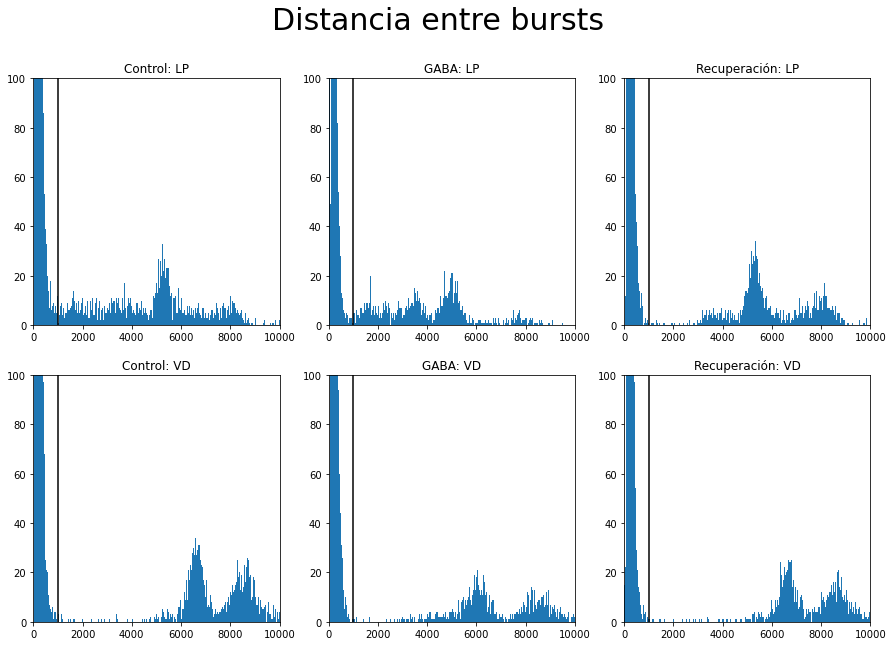

In [23]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre bursts", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=1000)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.ylim((0,100))
    plt.title(f"{titles[i]}: LP")
    
    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=1000)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.ylim((0,100))
    plt.title(f"{titles[i]}: VD")

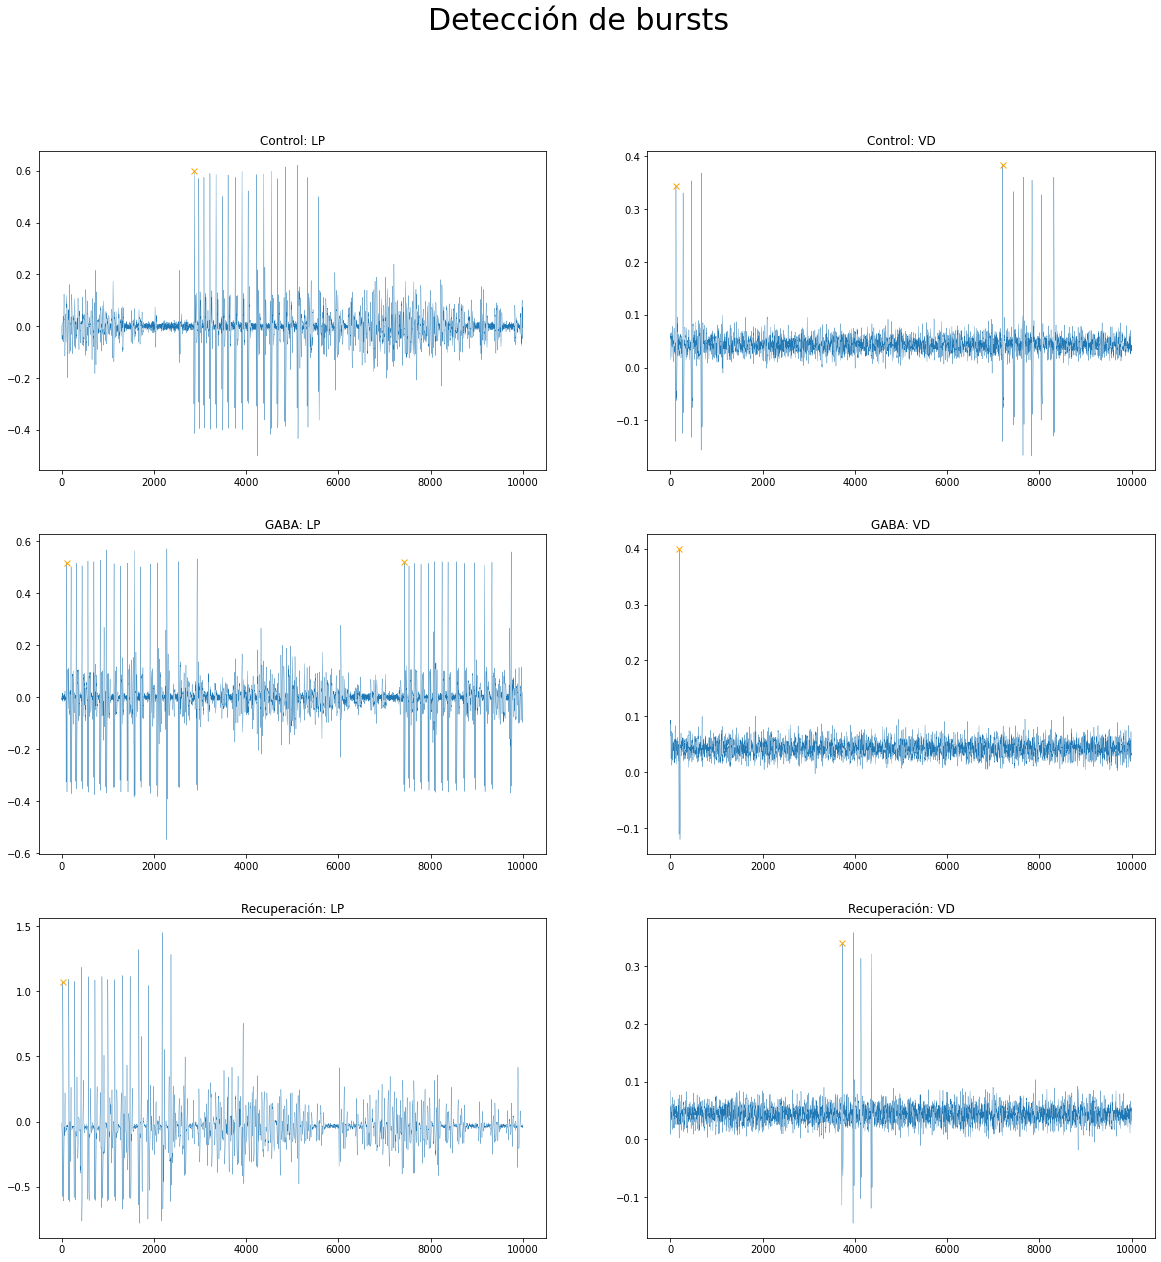

In [24]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoG.txt",
              "./DatosSinapsisArtificial/TrozoR.txt"]
bin_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
             "./DatosSinapsisArtificial/TrozoG_bin.csv",
             "./DatosSinapsisArtificial/TrozoR_bin.csv"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
burst_cols = [["LP_burst", "VD_burst"],
              ["LP_burst", "VD_burst"],
              ["LP_burst", "VD_burst"]]
bin_cols = [["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"]]
thresholds = [1000,1000,1000]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Detección de bursts", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False, nrows=10000)
    df2 = get_bursts(pd.read_csv(bin_files[i],nrows=10000), thresholds[i], bin_cols[i], burst_cols[i])
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.plot(df2[df2["LP_burst"] == 1]["LP"], 'x', c='orange')
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.plot(df2[df2["VD_burst"] == 1]["VD"], 'x', c='orange')
    plt.title(f"{titles[i]}: VD")

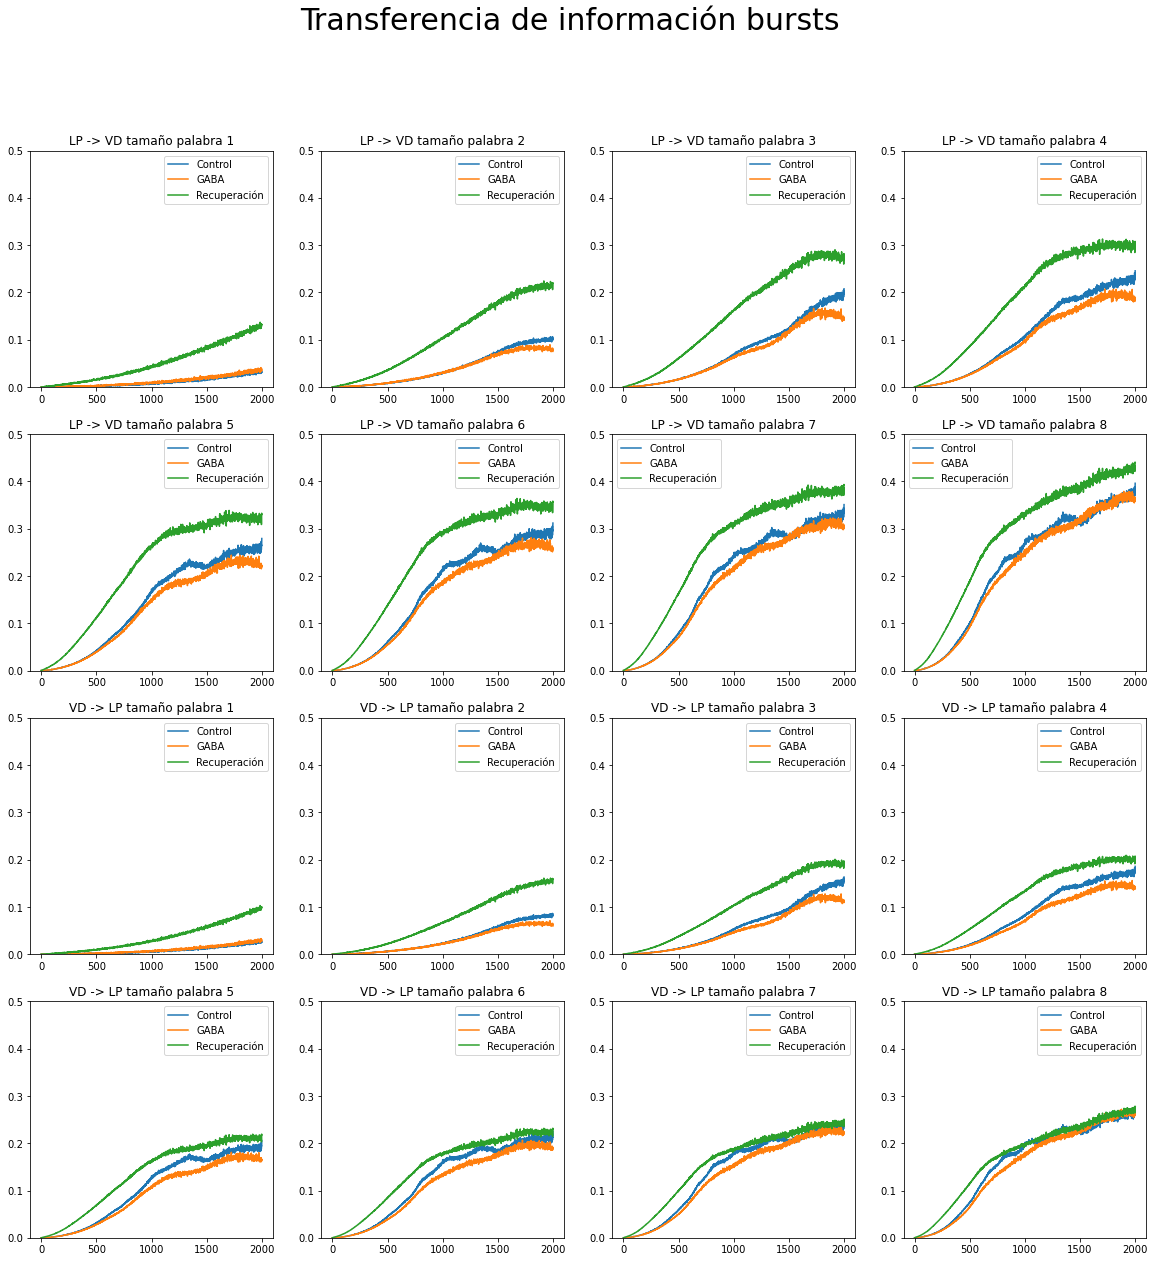

In [26]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información bursts", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.legend()

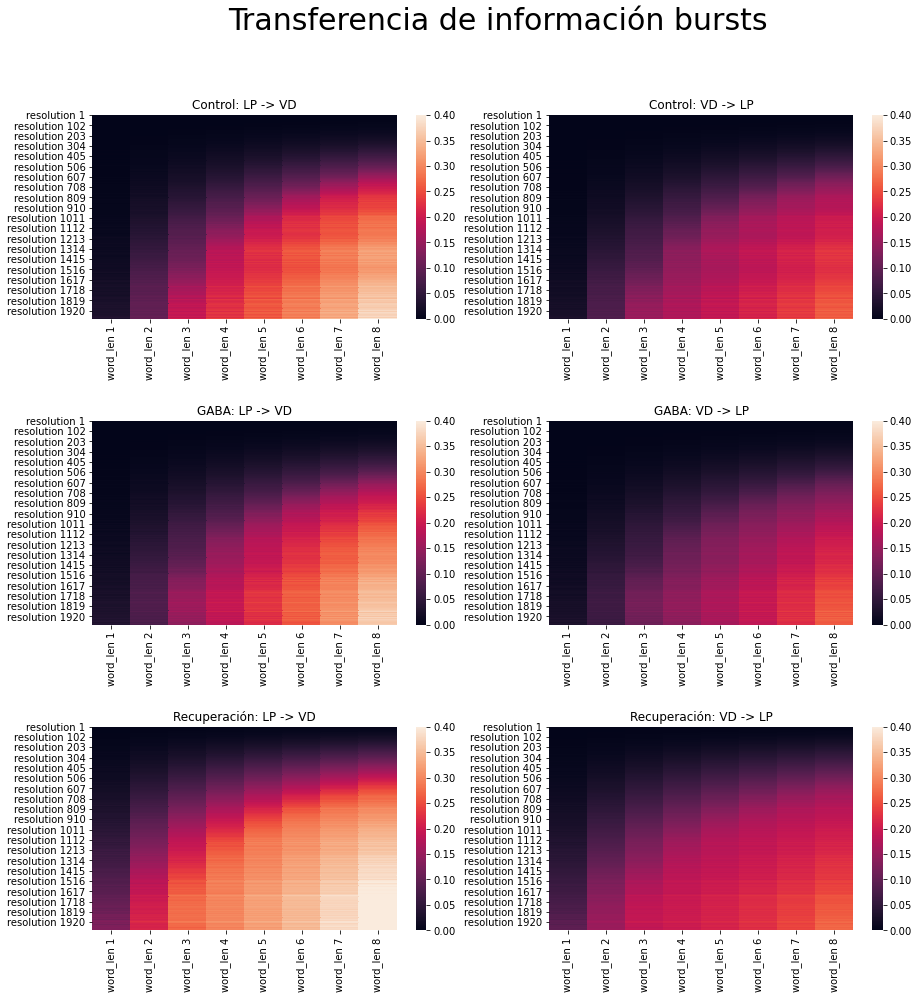

In [30]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información bursts", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: VD -> LP")